<a href="https://colab.research.google.com/github/Betsabeh/Python_codes-tutorial-/blob/main/Python_codes-tutorial-%20/advance_deep/CNN_transferlearning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms

from matplotlib import pyplot as plt
import numpy as np

In [13]:
batch_size = 50

In [14]:
# training data
train_data_transform = transforms.Compose([
transforms.Resize(224),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470,
0.2435, 0.2616))
])
Train_data = torchvision.datasets.CIFAR10(root='./data',train= True,download =True,transform= train_data_transform)
train_loader = torch.utils.data.DataLoader(Train_data,batch_size=batch_size, shuffle=True, num_workers=2)

In [15]:
# validation data
val_data_transform = transforms.Compose([
transforms.Resize(224),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435,
0.2616))
])
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=val_data_transform)

val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,shuffle=False, num_workers=2)

In [6]:
device = torch.device ("cuda:0" if torch.cuda.is_available() else 'cpu')

In [7]:
def train_model (model, loss_function, optimizer, data_loader ):
  model.train()
  current_loss = 0.0
  current_acc = 0
  for i ,(inputs, labels) in enumerate(data_loader):
    # send data to GPU
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
      # forward
      outputs = model(inputs)
      _ , predictions = torch.max(outputs, 1)
      loss = loss_function(outputs, labels)
      # backward
      loss.backward()
      optimizer.step()

    current_loss +=loss.item() * inputs.size(0)
    current_acc +=torch.sum(predictions == labels.data)

  total_loss = current_loss / len(data_loader.dataset)
  total_acc =current_acc.double ()/len (data_loader.dataset)
  print ("Train loss:{:.4f}; Acuuracy:{:,.4f}".format(total_loss, total_acc))



In [12]:
def test_model(model, loss_function,data_loader):
  model.eval()
  current_loss=0
  current_acc=0
  for i , (inputs, labels) in enumerate(data_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, predictions = torch.max(outputs, 1)
      loss = loss_function(outputs, labels)
      current_loss += loss.item() * inputs.size(0)
      current_acc += torch.sum(predictions == labels.data)

  total_loss = current_loss/(len(data_loader.dataset))
  total_acc = current_acc.double() / len(data_loader.dataset)
  print("Test loss:{:.4f}; Acuuracy:{:,.4f}".format(total_loss, total_acc))
  return total_loss, total_acc




In [21]:
# feature extraction using Resnet considering new layer at the end and train the last layer
def feature_extract(epochs =5):
  model = torchvision.models.resnet18(pretrained=True)
  #exclude existing parameters from backward pass
  for param in model.parameters():
    param.requies_grad = False

  #construct new layer contains 10 units
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, 10)
  model = model.to(device)


  Loss_function = nn.CrossEntropyLoss()

  # just the new layer weights being optimized
  optimizer = optim.Adam(model.fc.parameters())

  #train
  test_acc = []
  for epoch in range(epochs):
    print('epoch=', epoch)
    train_model(model, Loss_function, optimizer, train_loader)
    _ , total_acc= test_model(model, Loss_function, val_loader)
    test_acc.append(total_acc.cpu().item())

  print('hi')
  plt.figure()
  plt.plot(test_acc)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()





In [22]:
#fine tunning, we use Resnet18 but here train the whole network
def fine_tunning(epochs =5):
  #load resnet pretrain model
  model =torchvision.models.resnet18(pretrained=True)

  # new layer
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, 10)
  model = model.to(device)

  loss_function = nn.CrossEntropyLoss()
  optimizers = optim.Adam (model.parameters())

  test_acc = list()
  for epoch in range(epochs):
    train_model(model, loss_function, optimizers, train_loader)
    _ , total_acc= test_model(model, loss_function, val_loader)
    test_acc.append(total_acc.cpu().item())

  plt.figure()
  plt.plot(test_acc)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch= 0
Train loss:1.0490; Acuuracy:0.6411
Test loss:0.7182; Acuuracy:0.7552
epoch= 1
Train loss:0.8705; Acuuracy:0.6949
Test loss:0.6861; Acuuracy:0.7629
hi


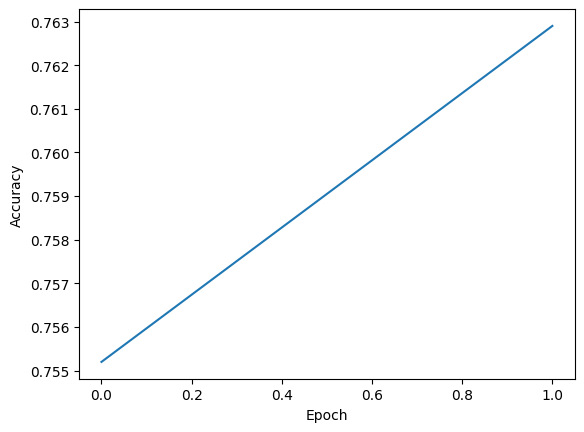

Train loss:0.8049; Acuuracy:0.7191
Test loss:0.6158; Acuuracy:0.7809
Train loss:0.5335; Acuuracy:0.8160
Test loss:0.5155; Acuuracy:0.8203


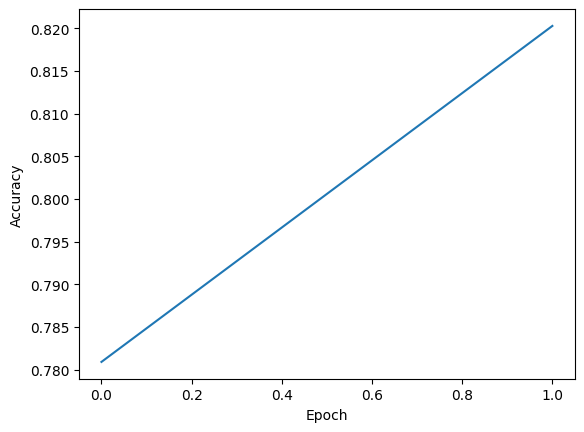

In [23]:
#comparing fine_tunning and just tunning the last layer
feature_extract(2)
fine_tunning(2)